Things I've fixed:  

* number of rows - pad at 100



Some timings on the validation data (so multiply by 10)

batch size: 56  
CUDA - CPU times: user 2min 13s, sys: 1.11 s, total: 2min 14s  
CPU - CPU times: user 1min 18s, sys: 3.22 s, total: 1min 21s  

batch size: 128  
CUDA - CPU times: user 1min 31s, sys: 651 ms, total: 1min 32s  
CPU - CPU times: user 1min 18s, sys: 3.22 s, total: 1min 21s  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import argparse
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
import logging
import os
import math
import copy
import matplotlib.pyplot as plt
import optuna
from datetime import datetime
import random
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
import copy

import scipy.stats

In [2]:
%matplotlib inline

In [3]:
import sys
sys.path.append('..')
import time

In [4]:
from src.data.data_loader import MIMICDataset,import_data
from src.utils import setup_logger
from src.training.training_nn import *
from src.utils import seed_everything
from src.data.data_scaler import PreProcess
from data.feature_sets import all_features

In [5]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [6]:
def pad_numpy(vec, pad):
    pad_size = list(vec.shape)
    pad_size[0] = pad - vec.shape[0]
    return np.concatenate([vec, np.zeros(pad_size)], axis=0)

In [7]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def import_data(path):
    df = pd.read_csv(path)
    ids = df.icustay_id.unique()
    for id_ in ids:
        df_id = df.loc[df.icustay_id == id_,:]
        if (sum(df_id.msk) == df_id.shape[0]):
            df.drop(df.loc[df.icustay_id == id_,:].index,inplace=True)
            print("excluding:",id_)
    return df

TIME_VARS = ["timer","timer_dt"]

def pad_numpy(vec, pad, val="zeros"):
    pad_size = list(vec.shape)
    pad_size[0] = pad - vec.shape[0]
    if val == "zeros":
        out = np.concatenate([vec, np.zeros(pad_size)], axis=0)
    elif val == "ones":
        out = np.concatenate([vec, np.ones(pad_size)], axis=0)
    return out

TIME_VARS = ["timer","timer_dt"]

class MIMICDataset(Dataset):
    """
    Args:
        patientunitstayids: 
        df:
        ...
    
    Example:
    """
    def __init__(self,df,features,pad=100,maxrows=100,verbose=True):
        self.pad = pad
        self.maxrows = maxrows
        self.X,self.y,self.msk,self.dt = self.load_data(df,features,verbose=verbose)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # pad
        X = self.X[idx].astype(np.float32)
        y = self.y[idx].astype(np.float32)
        msk = self.msk[idx].astype(np.int32)
        dt = self.dt[idx].astype(np.float32)

        return X,y,msk,dt
    
    def load_data(self,df,features,verbose):
        excl = []
        n_excl_pt = 0
        n_excl_rws = 0
        X_list, y_list, msk_list, dt_list = [], [], [], []
        ids = df.icustay_id.unique()
        if verbose:
            print("reconfiguring data...")
        for id_ in ids:
            df_id = df.loc[df.icustay_id == id_,:].iloc[0:self.maxrows]
            if (sum(df_id.msk) == df_id.shape[0]):
                #print("excluding:",id_)
                n_excl_pt += 1
                n_excl_rws +=  df_id.loc[df_id.msk == 0].shape[0]
                continue
            # additional exclusions
#             if ((max(df_id.timer)/24 > 7.0) or (max(df_id.timer) < 6.0)):
#                 print("excluding (time):",id_)
#                 continue
            n_days_gl = (max(df_id.timer_dt) - min(df_id.timer))/24
            n_gl_meas = df_id.loc[df_id.msk == 0].shape[0]
            if (n_gl_meas/n_days_gl < 1.0):
                n_excl_pt += 1
                n_excl_rws +=  df_id.loc[df_id.msk == 0].shape[0]
                #print("excluding (<1/day):",id_)
                continue
            X = df_id.loc[:,features]
            y = df_id.loc[:,"glc_dt"]
            msk = df_id.loc[:,"msk"]
            dt = df_id.loc[:,TIME_VARS]
            X = np.array(X).astype(np.float32)
            y = np.array(y).astype(np.float32)
            msk = np.array(msk).astype(np.int32)
            dt = np.array(dt).astype(np.float32)
            X_list.append(X)
            y_list.append(y)
            msk_list.append(msk)
            dt_list.append(dt)
        print("excluded patients:",n_excl_pt)
        print("excluded rows:",n_excl_rws)
        return X_list,y_list,msk_list,dt_list

In [23]:
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    lengths = torch.tensor([b[0].shape[0] for b in batch])
    ## padd
    x = [torch.Tensor(b[0]) for b in batch]
    y = [torch.Tensor(b[1]) for b in batch]
    msk = [torch.Tensor(b[2]) for b in batch]
    dt = [torch.Tensor(b[3]) for b in batch]
    x = torch.nn.utils.rnn.pad_sequence(x,batch_first=True)
    y = torch.nn.utils.rnn.pad_sequence(y,batch_first=True)
    msk = torch.nn.utils.rnn.pad_sequence(msk,batch_first=True,padding_value=int(1))
    dt = torch.nn.utils.rnn.pad_sequence(dt,batch_first=True)
    return x, y, msk, dt

In [9]:
df = pd.read_csv('../data/train.csv')
train_ids, valid_ids = train_test_split(df.icustay_id.unique(),test_size=0.1)
df_train = df.loc[df.icustay_id.isin(train_ids)]
df_valid = df.loc[df.icustay_id.isin(valid_ids)]
FEATURES = all_features()
NFEATURES = len(all_features())
preproc = PreProcess(FEATURES,QuantileTransformer())
preproc.fit(df_train)
df_train = preproc.transform(df_train)
df_valid = preproc.transform(df_valid)

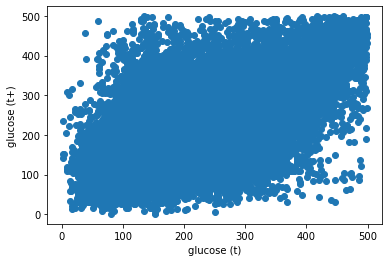

In [10]:
plt.scatter(df.glc,df.glc_dt)
plt.xlabel("glucose (t)")
plt.ylabel("glucose (t+)")
plt.show()

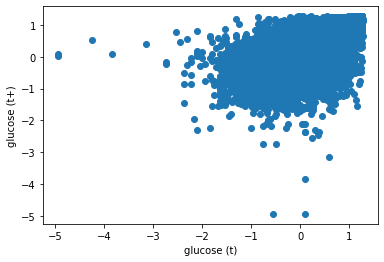

In [11]:
plt.scatter(df_train.glc,df_train.glc_dt)
plt.xlabel("glucose (t)")
plt.ylabel("glucose (t+)")
plt.show()

(array([2.00000e+00, 2.00000e+00, 1.00000e+00, 5.00000e+00, 2.60000e+01,
        2.65000e+02, 6.91300e+03, 1.14916e+05, 8.48770e+04, 1.10940e+04]),
 array([-4.94164242, -4.32038181, -3.6991212 , -3.07786059, -2.45659998,
        -1.83533937, -1.21407877, -0.59281816,  0.02844245,  0.64970306,
         1.27096367]),
 <BarContainer object of 10 artists>)

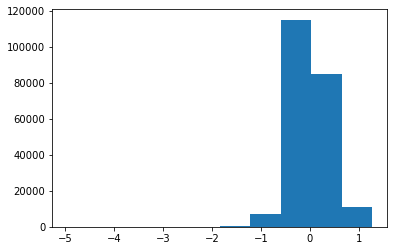

In [12]:
plt.hist(df_train.glc)

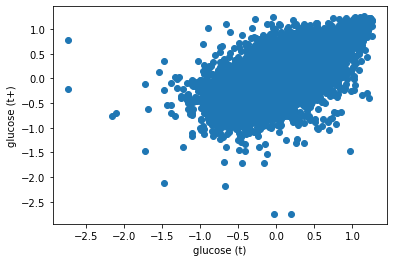

In [13]:
plt.scatter(df_valid.glc,df_valid.glc_dt)
plt.xlabel("glucose (t)")
plt.ylabel("glucose (t+)")
plt.show()

In [14]:
math.sqrt(np.mean((ginv(df_train.loc[df_train.msk==0,'glc']) - ginv(df_train.loc[df_train.msk==0,'glc_dt']))**2))

42.99370427578497

In [15]:
math.sqrt(np.mean((ginv(df_valid.loc[df_valid.msk==0,'glc']) - ginv(df_valid.loc[df_valid.msk==0,'glc_dt']))**2))

42.25510215894564

In [25]:
dl_train = DataLoader(MIMICDataset(df_train,FEATURES),batch_size=16,pin_memory=False,collate_fn=collate_fn_padd)
dl_valid = DataLoader(MIMICDataset(df_valid,FEATURES),batch_size=128,pin_memory=False,collate_fn=collate_fn_padd)
dataloaders = {'train':dl_train,'validation':dl_valid}

reconfiguring data...
excluded patients: 226
excluded rows: 653
reconfiguring data...
excluded patients: 25
excluded rows: 49


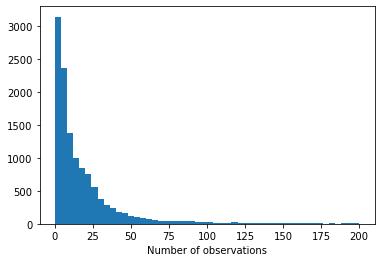

In [17]:
plt.hist(df.groupby(['icustay_id']).size(),range=[0,200],bins=50)
plt.xlabel('Number of observations')
plt.show()

In [83]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import math

import torch.nn.functional as F

class Baseline(nn.Module):
    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        super(Baseline, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.p = p
        self.device = device
        
    def train_single_epoch(self,dataloader,optim,verbose=True):
        loss = 0.0
        n_batches = len(dataloader)
        print("number of batchs: {}".format(n_batches))
        for i, (x, y, msk, dt) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.to(self.device)
            dt = dt.to(self.device)
            msk = msk.bool().to(self.device)
            optim.zero_grad()
            preds = self.forward(dt,x)
            loss_step = self.loss_fn(preds,y,~msk.view(x.shape[0],-1))
            loss_step.backward()
            #torch.nn.utils.clip_grad_norm_(self.parameters(), 10.0)
            optim.step()
            loss += loss_step.item()
            if (i % int(n_batches/10) == 0) & verbose:
                print("Batch number: {}".format(i))
                print("BATCH_loss : {:05.3f}".format(loss_step.item()))
        loss /= (i + 1)
        print("EPOCH_loss : {:05.3f}".format(loss))
        
        return loss
        
    def evaluate(self,dataloader,p=0.0):
        
        rmse, loss = 0., 0.
        N = 0
        y_preds = []
        y_tests = []
        msks = []
        #dts = []
        with tqdm(total=len(dataloader)) as t:
            for i, (x, y, msk, dt) in enumerate(dataloader):
                N += sum(sum(msk == 0)).item()
                x = x.to(self.device)
                y = y.to(self.device)
                dt = dt.to(self.device)
                # model prediction
                y_ = self.forward(dt,x)
                y_preds.append([yc.detach().cpu().numpy() for yc in y_]) 
                y_tests.append(y.cpu().numpy())
                msk = msk.bool().to(self.device)
                rmse += self.get_sse(y_,y,~msk.view(x.shape[0],-1)).item()
                loss += self.loss_fn(y_,y,~msk.view(x.shape[0],-1)).item()
                msks.append(msk.cpu().numpy())
                t.update()
        rmse /= N
        loss /= (i + 1)
        rmse = math.sqrt(rmse)
        print("_rmse : {:05.3f}".format(rmse))
        print("_loss : {:05.3f}".format(loss))
        return loss,rmse, y_preds, y_tests, msks

    def get_sse(self,y_,y,msk):
        """
        SSE: sum of squared errors
        """
        if type(y_) == tuple:
            y_ = y_[0]
        y_ = y_.squeeze(2)
        c = torch.log(torch.tensor(140.0))
        rmse = torch.sum((torch.exp(y_[msk] + c) - torch.exp(y[msk] + c))**2)
        return rmse

In [ ]:
class ODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,input_dim,device):
        super(ODEFunc, self).__init__()
        
        self.x = torch.zeros(128,100,6).to(device)
        self.dt = torch.zeros(128,100,1).to(device)
        self.device = device
        self.net = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, z):
        xz = torch.cat((z,self.x),2)
        out = self.net(xz)
        out = out * (self.dt/100) # -> scale by timestep
        return out 
    
    def solve_ode(self, x0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, x0, torch.tensor([0,1.0]).to(self.device),rtol=1e-3, atol=1e-3)[1]
        return outputs
    
class neuralODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = ODEFunc(input_dim,device).to(device)
        
    def forward(self, dt, x):
        
        #x = x.squeeze(0)
        #dt = dt.squeeze(0)
        T = x.size(1)
        
        # ODE
        mu_out = torch.zeros(x.size(0),T,1,device = self.device)
        for i in range(0,T):
            y0 = x[:,i:(i+1),0:1]
            x_i = x[:,i:(i+1),1:]
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1).unsqueeze(1)
            mu_out[:,i:(i+1),:] = self.func.solve_ode(y0,dt_i,x_i)

        return mu_out
    
    def loss_fn(self,y_,y,msk):
        return torch.sum((y_[msk] - y[msk])**2)

In [ ]:
x,y,msk,dt = next(iter(dl_train))
n_ode = neuralODE(NFEATURES,1,0.0,1,"cuda").to("cuda")
n_ode(dt.to("cuda"),x.to("cuda")).shape

In [ ]:
nepochs = 2
n_ode = neuralODE(NFEATURES,1,0.0,1,"cpu").to("cpu")
model_optim = optim.Adam(n_ode.parameters(), lr=1e-3)
start_time = time.time()
for epoch in range(0,nepochs):
    print("EPOCH: {}".format(epoch))
    %time n_ode.train_single_epoch(dl_train,model_optim)
current_time = time.time()
elapsed_time = current_time - start_time
print(elapsed_time)

In [ ]:
# evaluate - averages

In [ ]:
loss,rmse, y_preds, y_tests, msks = n_ode.evaluate(dl_valid)
print(rmse)
print(loss)

y_preds = (np.concatenate(y_preds))
y_tests = (np.concatenate(y_tests))
msk = (np.concatenate(msks))

diff = y_preds - y_tests
print(np.mean(diff[~msk]**2))
print(np.std(y_tests[~msk]))

In [ ]:
plt.hist(y_tests[~msk],bins=20)
plt.show()
plt.hist(y_preds[~msk],bins=20)
plt.show()

In [ ]:
plt.scatter(y_preds[~msk],y_tests[~msk])
plt.show()
c = np.log(140)
plt.scatter(ginv(y_preds[~msk]),ginv(y_tests[~msk]))
plt.show()

In [ ]:
N = 20
res = np.zeros(N)
Y0 = torch.linspace(-1.0,1.0,N)
y0 = torch.zeros(1,1,1)
dt = torch.ones(1,1,1).to("cuda")
n_ode.func.x = torch.zeros(1,1,1).to("cuda")
n_ode.func.dt = dt
for i in range(0,N):
    y0[0,0,0] = Y0[i]
    with torch.no_grad():
        res[i] = n_ode.func(dt,y0.to("cuda")).cpu().numpy().item()

In [ ]:
Y0 = Y0.cpu().numpy()
plt.scatter(Y0,res)

In [ ]:
plt.scatter(Y0,Y0 + res)

In [ ]:
ts = np.linspace(0,1,10)
fig, ax = plt.subplots(1, 1, tight_layout=True)
for t in ts:
    for i in range(N):
        dy =  np.exp(Y0[i]+res[i]+np.log(140)) - np.exp(Y0[i]+np.log(140))
        ax.arrow(t,np.exp(Y0[i]+np.log(140)),0.09,dy, width = 0.008)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Blood glucose (mg/dL)")
fig.savefig('tmp.jpg', bbox_inches='tight', dpi=150)

In [ ]:
####################################################################################################

In [106]:
class LODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,hidden_dim,input_dim,device):
        super(LODEFunc, self).__init__()

        self.x = torch.zeros(128,100,input_dim).to(device)
        self.dt = torch.zeros(128,100,1).to(device)
        self.device = device
        self.net = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, hidden_dim * 2),
            nn.Tanh(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, z):
        xz = torch.cat((z,self.x),2)
        out = self.net(xz)
        out = out #* (self.dt/100) # -> scale by timestep
        return out 

    def solve_ode(self, z0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, z0, torch.tensor([0,1.0]).to(self.device),rtol=1e-1, atol=1e-1,method="euler")[1]
        return outputs
    
class latentODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = LODEFunc(hidden_dim,input_dim,device).to(device)
        self.mu_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        ).to(device)
        self.sigma_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        ).to(device)
        self.encode_z0 = nn.Sequential(
            nn.Linear(input_dim, max(hidden_dim,hidden_dim) // 2),
            nn.Tanh(),
            nn.Linear(max(hidden_dim,hidden_dim) // 2, hidden_dim),
            nn.Tanh(),
        ).to(device)
        
#         for m in self.encode_z0.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)
        
    def forward(self, dt, x):
        
        #x = x.squeeze(0)
        batch_size = x.size(0)
        T = x.size(1)
        
        # ODE
        mu_out = torch.zeros(batch_size,T,1,device = self.device)
        s_out = torch.zeros(batch_size,T,1,device = self.device)
        #z0 = 0.01 * torch.randn(batch_size,1,self.hidden_dim,device = self.device)
        z0 = self.encode_z0(x[:,0,:]).unsqueeze(1)
        for i in range(0,T):
            x_i = x[:,i:(i+1),:]
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1).unsqueeze(1)
            z0 = self.func.solve_ode(z0,dt_i,x_i)
            mu_out[:,i:(i+1),:] = self.mu_net(z0.squeeze(1)).unsqueeze(1)
            s_out[:,i:(i+1),:] = self.sigma_net(z0.squeeze(1)).unsqueeze(1)

        return (mu_out,s_out)
    
    def loss_fn(self,mu_s_,y,msk):
        y_, s_ = mu_s_
        distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk])
        return -torch.mean(likelihood)
    
#     def loss_fn(self,y_,y,msk):
#         return sum((y_[msk] - y[msk])**2)

In [107]:
# tmp = MIMICDataset(df_train.iloc[0:100],FEATURES)

In [108]:
# dl_check = DataLoader(tmp,batch_size=1,pin_memory=False,collate_fn=collate_fn_padd)

In [109]:
l_ode = latentODE(NFEATURES,8,0.0,1,"cpu")
x,y,msk,dt = next(iter(dl_valid))
y_ = l_ode(dt,x)
loss = l_ode.loss_fn(y_,y,~msk.bool().view(x.shape[0],-1))
print(loss)
loss.backward()

tensor(0.6536, grad_fn=<NegBackward>)


In [110]:
y_[0].shape

torch.Size([128, 100, 1])

In [111]:
y_,s_ = y_

In [112]:
y_[~msk.bool().view(x.shape[0],-1)].shape

torch.Size([2595, 1])

In [113]:
math.sqrt(np.mean((ginv(y_[~msk.bool().view(x.shape[0],-1)].detach().numpy()) - ginv(y[~msk.bool().view(x.shape[0],-1)].numpy()))**2).item())

64.75305781269137

In [114]:
# for p in l_ode.parameters():
#     print(p.shape)

In [115]:
# nepochs = 10
# l_ode = latentODE(NFEATURES,10,0.1,1,"cpu")
# model_optim = optim.Adam(l_ode.parameters(), lr=1e-3)
# start_time = time.time()
# for epoch in range(0,nepochs):
#     print("EPOCH: {}".format(epoch))
#     l_ode.train_single_epoch(dl_check,model_optim,verbose=False)
#     total_norm = 0.0
#     for p in l_ode.parameters():
#         param_norm = p.grad.detach().data.norm(2)
#         total_norm += param_norm.item() ** 2
#         total_norm = total_norm ** 0.5
#     print(total_norm)
# current_time = time.time()
# elapsed_time = current_time - start_time
# print("time: {}".format(elapsed_time))
# l_ode.evaluate(dl_check)

In [116]:
l_ode = latentODE(NFEATURES,10,0.1,1,"cpu")
model_optim = optim.Adam(l_ode.parameters(), lr=1e-3)

In [119]:
nepochs = 5
l_ode = latentODE(NFEATURES,8,0.1,1,"cpu")
model_optim = optim.Adam(l_ode.parameters(), lr=1e-3)
start_time = time.time()
for epoch in range(0,nepochs):
    print("EPOCH: {}".format(epoch))
    l_ode.train_single_epoch(dl_valid,model_optim)
    total_norm = 0.0
    for p in l_ode.parameters():
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
    print("NORM: {}".format(total_norm))
    _ = l_ode.evaluate(dl_valid)
current_time = time.time()
elapsed_time = current_time - start_time
print("time: {}".format(elapsed_time))

EPOCH: 0
number of batchs: 10
Batch number: 0
BATCH_loss : 0.687
Batch number: 1
BATCH_loss : 0.605
Batch number: 2
BATCH_loss : 0.617
Batch number: 3
BATCH_loss : 0.562
Batch number: 4
BATCH_loss : 0.499
Batch number: 5
BATCH_loss : 0.535
Batch number: 6
BATCH_loss : 0.470
Batch number: 7
BATCH_loss : 0.489
Batch number: 8
BATCH_loss : 0.490
Batch number: 9
BATCH_loss : 0.425
EPOCH_loss : 0.538
NORM: 1.007918480019833


100%|██████████| 10/10 [00:00<00:00, 12.91it/s]


_rmse : 58.101
_loss : 0.456
EPOCH: 1
number of batchs: 10
Batch number: 0
BATCH_loss : 0.469
Batch number: 1
BATCH_loss : 0.461
Batch number: 2
BATCH_loss : 0.491
Batch number: 3
BATCH_loss : 0.438
Batch number: 4
BATCH_loss : 0.387
Batch number: 5
BATCH_loss : 0.454
Batch number: 6
BATCH_loss : 0.378
Batch number: 7
BATCH_loss : 0.403
Batch number: 8
BATCH_loss : 0.421
Batch number: 9
BATCH_loss : 0.349
EPOCH_loss : 0.425
NORM: 1.0027438749648747


100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


_rmse : 56.407
_loss : 0.401
EPOCH: 2
number of batchs: 10
Batch number: 0
BATCH_loss : 0.441
Batch number: 1
BATCH_loss : 0.420
Batch number: 2
BATCH_loss : 0.435
Batch number: 3
BATCH_loss : 0.389
Batch number: 4
BATCH_loss : 0.343
Batch number: 5
BATCH_loss : 0.420
Batch number: 6
BATCH_loss : 0.341
Batch number: 7
BATCH_loss : 0.366
Batch number: 8
BATCH_loss : 0.389
Batch number: 9
BATCH_loss : 0.320
EPOCH_loss : 0.386
NORM: 1.0031808763453656


100%|██████████| 10/10 [00:00<00:00, 12.49it/s]


_rmse : 55.855
_loss : 0.373
EPOCH: 3
number of batchs: 10
Batch number: 0
BATCH_loss : 0.413
Batch number: 1
BATCH_loss : 0.396
Batch number: 2
BATCH_loss : 0.415
Batch number: 3
BATCH_loss : 0.367
Batch number: 4
BATCH_loss : 0.318
Batch number: 5
BATCH_loss : 0.404
Batch number: 6
BATCH_loss : 0.323
Batch number: 7
BATCH_loss : 0.348
Batch number: 8
BATCH_loss : 0.377
Batch number: 9
BATCH_loss : 0.304
EPOCH_loss : 0.367
NORM: 1.0019624289018594


100%|██████████| 10/10 [00:00<00:00, 12.90it/s]


_rmse : 55.832
_loss : 0.361
EPOCH: 4
number of batchs: 10
Batch number: 0
BATCH_loss : 0.410
Batch number: 1
BATCH_loss : 0.389
Batch number: 2
BATCH_loss : 0.408
Batch number: 3
BATCH_loss : 0.357
Batch number: 4
BATCH_loss : 0.304
Batch number: 5
BATCH_loss : 0.398
Batch number: 6
BATCH_loss : 0.311
Batch number: 7
BATCH_loss : 0.337
Batch number: 8
BATCH_loss : 0.369
Batch number: 9
BATCH_loss : 0.293
EPOCH_loss : 0.357
NORM: 1.0014354753039014


100%|██████████| 10/10 [00:00<00:00, 12.79it/s]

_rmse : 55.723
_loss : 0.354
time: 10.946430683135986


In [120]:
loss,rmse, y_preds, y_tests, msks = l_ode.evaluate(dl_valid)

100%|██████████| 10/10 [00:00<00:00, 11.83it/s]

_rmse : 55.723
_loss : 0.354


In [136]:
yy_ = [y_preds[0][0] for y in y_preds]

In [144]:
yy_[0]

array([[[-0.10888918],
        [-0.08375314],
        [-0.05255094],
        ...,
        [-0.0261258 ],
        [-0.0261258 ],
        [-0.0261258 ]],

       [[-0.11026572],
        [-0.09858496],
        [-0.08384787],
        ...,
        [-0.0261258 ],
        [-0.0261258 ],
        [-0.0261258 ]],

       [[-0.10506231],
        [-0.04531836],
        [-0.01691126],
        ...,
        [-0.0261258 ],
        [-0.0261258 ],
        [-0.0261258 ]],

       ...,

       [[-0.06881031],
        [-0.02902762],
        [-0.00883945],
        ...,
        [-0.0261258 ],
        [-0.0261258 ],
        [-0.0261258 ]],

       [[-0.10076755],
        [-0.08714579],
        [-0.08172697],
        ...,
        [-0.0261258 ],
        [-0.0261258 ],
        [-0.0261258 ]],

       [[-0.1071846 ],
        [-0.10667901],
        [-0.10624893],
        ...,
        [-0.0261258 ],
        [-0.0261258 ],
        [-0.0261258 ]]], dtype=float32)

In [ ]:
y_preds = (np.concatenate(y_preds))
y_tests = (np.concatenate(y_tests))
msk = (np.concatenate(msks))

In [ ]:
plt.scatter(ginv(y_preds[~msk]),ginv(y_tests[~msk]))
plt.show()

In [ ]:
##########################################################################################################

In [ ]:
# linear system of z = (g,h)

In [ ]:
 class recurrentODE_(nn.Module):
    """
    (dglucose/dt,dh/dt) = (RNN(glucose,h),NN(h,x))
    """
    def __init__(self,hidden_dim,input_dim,batch_size,device):
        super(recurrentODE_, self).__init__()
        
        self.x = torch.zeros(batch_size,100,input_dim).to(device)
        self.dt = torch.zeros(batch_size,100,1).to(device)
        self.device = device
        # dh/dt
        self.dh = nn.Sequential(
            nn.Linear(hidden_dim+input_dim, (hidden_dim+input_dim)*2),
            nn.ReLU(),
            nn.Linear((hidden_dim+input_dim)*2, hidden_dim),
            nn.Tanh(),
        ).to(device)
        # dy/dt
        self.dy_rnn = nn.RNNCell(input_dim, hidden_dim)
        self.dy_lin = nn.Linear(hidden_dim, 1)
        self.dy_tanh = nn.Tanh()

        for m in self.dh.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
        nn.init.normal_(self.dy_rnn.weight_ih,mean=0, std=0.1)
        nn.init.normal_(self.dy_rnn.weight_hh,mean=0, std=0.1)
        nn.init.constant_(self.dy_rnn.bias_ih, val=0)
        nn.init.constant_(self.dy_rnn.bias_ih, val=0)
        nn.init.normal_(self.dy_lin.weight,mean=0, std=0.1)
        nn.init.constant_(self.dy_lin.bias, val=0)

    def forward(self, t, z):
        # dh/dt
        #dh = self.dh(z[:,:,1:])*self.dt
        dh = self.dh(torch.cat((self.x,z[:,:,1:]),2)) * (self.dt / 50)
        # dy/dt
        #dy = self.dy_rnn(self.x.squeeze(1),z[:,:,1:].squeeze(1)) # hidden should be shape (1,batch,hidden)
        #dy = self.dy_lin(dy.unsqueeze(1))
        dy = self.dy_lin(z[:,:,1:])
        dy = self.dy_tanh(dy) * (self.dt / 50)
        return torch.cat((dy,dh),2)
    
    def solve_ode(self, z0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, z0, torch.tensor([0,1.0]).to(self.device),rtol=1e-1, atol=1e-1)[1]
        return outputs
    
class recurrentODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim,batch_size, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.batch_size = batch_size
        self.func = recurrentODE_(hidden_dim,input_dim,batch_size,device).to(device)
        
    def forward(self, dt, x, seqlen=0):
        
        #x = x.squeeze(0)
        batch_size = x.size(0)
        T = x.size(1)

        # ODE stuff
        mu_out = torch.zeros(batch_size,T,1,device = self.device)
        z0 = torch.zeros(batch_size,1,self.hidden_dim+1,device = self.device)
        for i in range(0,T):
            x_i = x[:,i:(i+1),:]
            y0 = x[:,i:(i+1),0:1]
            z0[:,:,0:1] = y0
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1).unsqueeze(1)
            z0 = self.func.solve_ode(z0,dt_i,x_i)
            mu_out[:,i:(i+1),:] = z0[:,:,0:1]

        return mu_out
    
    def loss_fn(self,y_,y,msk):
        return torch.mean((y_[msk] - y[msk])**2)

In [ ]:
nepochs = 5
batch_size = 128
r_ode = recurrentODE(NFEATURES,4,0.0,1,batch_size,"cuda").to("cuda")
model_optim = optim.Adam(r_ode.parameters(), lr=1e-2)
start_time = time.time()
for epoch in range(0,nepochs):
    print("EPOCH: {}".format(epoch))
    r_ode.train_single_epoch(dl_train,model_optim)
current_time = time.time()
elapsed_time = current_time - start_time
print("time: {}".format(elapsed_time))

In [ ]:
loss,rmse, y_preds, y_tests, msks = r_ode.evaluate(dl_valid)

In [ ]:
_rmse : 41.815
_loss : 0.068

In [ ]:
#################################################################################

In [ ]:
# ODE-RNN

In [ ]:
class ODERNN_(nn.Module):
    """
    In an ODE-RNN the hidden state h_t of the RNN evolves according to
    an ODE. This ODE is a neural network, i.e. dh/dt = ODEFunc(h,x).
    """
    def __init__(self,hidden_dim,device):
        super(ODERNN_, self).__init__()

        self.x = torch.zeros(128,100,6).to(device)
        self.dt = torch.zeros(128,100,1).to(device)
        self.device = device
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_dim),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, dt, y):
        out = self.net(y)
        out = out * (self.dt / 100)
        return out
    
    def solve_ode(self, z0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, z0, torch.tensor([0,1.0]).to(self.device),rtol=1e-1, atol=1e-1)[1]
        return outputs

class ODERNN(Baseline):
    """
    ODE-RNN
    """
    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        # ODE-RNN
        self.rnn = nn.RNNCell(input_dim, hidden_dim)
        self.func = ODERNN_(hidden_dim,device)
        # N(mu,sigma)
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(hidden_dim,hidden_dim//2)
        self.distribution_mu = nn.Linear(hidden_dim//2, 1)

    def forward(self, dt, x, p=0.0):
        
        T = x.size(1)

        batch_size = x.size(0)
        mu_out = torch.zeros(batch_size,T,1,device = self.device)
        h_t = torch.zeros(batch_size, self.rnn.hidden_size,device=self.device)
        for i in range(0,T):
            x_i = x[:,i:(i+1),:]
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1)
            h_t = self.rnn(x_i.squeeze(1),h_t)
            h_t = self.func.solve_ode(h_t,dt_i,x_i)
            mu = self.l1(h_t)
            mu = F.dropout(mu,training=True,p=p)
            mu = self.relu(mu)
            mu_out[:,i:(i+1),:] = self.distribution_mu(mu).unsqueeze(1)

        return mu_out
    
    def loss_fn(self,y_,y,msk):
        return torch.mean((y_[msk] - y[msk])**2)

In [ ]:
nepochs = 5
rnn_ode = ODERNN(NFEATURES,6,0.1,1,"cuda").to("cuda")
model_optim = optim.Adam(rnn_ode.parameters(), lr=1e-2)
start_time = time.time()
for epoch in range(0,nepochs):
    print("EPOCH: {}".format(epoch))
    rnn_ode.train_single_epoch(dl_train,model_optim)
current_time = time.time()
elapsed_time = current_time - start_time
print("time: {}".format(elapsed_time))

In [ ]:
loss,rmse, y_preds, y_tests, msks = rnn_ode.evaluate(dl_valid)

In [ ]:
_rmse : 43.876
_loss : 0.062

_rmse : 53.869
_loss : 0.092

In [ ]:
x,y,msk,dt,_ = next(iter(dl_train))

In [ ]:
plt.hist((dt[:,3,:][:,1] - dt[:,3,:][:,0]).unsqueeze(1).numpy()/50)

In [ ]:
1/50